In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import gc
from functools import reduce

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from ignite.engine import create_supervised_evaluator

import json

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


if '../src' not in sys.path:
    sys.path.append('../src')
    
# from dataset.sprites import SupervisedLoader, BatchGenerator, UnsupervisedLoader, load_raw
from analysis.traversal import traverse_all
from analysis.metrics import DCIMetrics
from analysis.hinton import hinton
from analysis.testing import infer, model_scores, get_recons
from training.loss import get_metric

if '../scripts/' not in sys.path:
    sys.path.append('../scripts/')

from ingredients.autoencoders import init_lgm
from analysis.utils import load_lgm, load_dataset

# Disable grad globally
torch.set_grad_enabled(False)

# Config options
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set(color_codes=True);

# Save folder
# presentation_folder = '/home/milton/Dropbox/Apps/Overleaf/Presentation: Compositionality in Generative Models/plots/'

## Load dataset

In [3]:
# dSprites

train_data, test_data = load_dataset('dsprites', 'recomb2range', 'shape2tx')
# train_data, test_data = load_dataset('dsprites', 'recomb2element', 'leave1out')
# train_data, test_data = load_dataset('dsprites', 'extrp', 'blank_side')

# 3DShapes
train_data, test_data = load_dataset('shapes3d', 'recomb2range', 'shape2ohue')
# train_data, test_data = load_dataset('shapes3d', 'recomb2element', 'leave1out')
# train_data, test_data = load_dataset('shapes3d', 'extrp', 'fhue_gt50')

# MPI (Add later)

## Load models

In [4]:
vae = load_lgm('../data/sims/disent/dsprites/', 39, device) 
beta_8 = load_lgm('../data/sims/disent/dsprites/', 85, device)
factor_20 = load_lgm('../data/sims/disent/dsprites/', 2, device)
factor_50 = load_lgm('../data/sims/disent/dsprites/', 6, device)

models = [vae, beta_8, factor_20, factor_50]
model_names = ['VAE', '{0}-VAE({0}=8)'.format(chr(946)), 'FactorVAE({}=20)'.format(chr(957)), 'FactortVAE({}=50)'.format(chr(957))]

# Tests

## Reconstructions

In [5]:
batch_size=5

train_inputs = next(iter(DataLoader(train_data.get_supervised(), batch_size=batch_size, shuffle=True)))
train_recons = np.stack([get_recons(train_inputs[0].flatten(start_dim=1), m, device) for m in models])

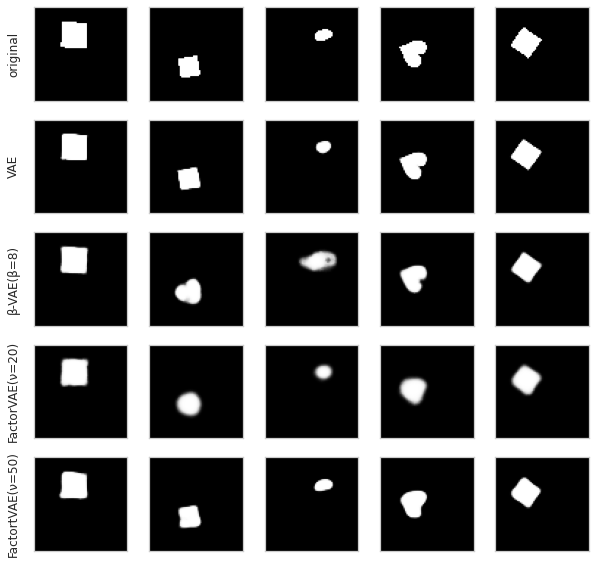

In [6]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig, axes = plt.subplots(len(models) + 1, batch_size, figsize=(2 * batch_size, 10))

images = np.concatenate([train_inputs[0].unsqueeze(0).numpy(), train_recons])

for j, (examp_imgs, ylab) in enumerate(zip(images, ['original'] + model_names)):
    for i, img in enumerate(examp_imgs):
        axes[j, i].imshow(img.reshape(64, 64), cmap='Greys_r')
        if i == 0:
            axes[j, i].set_ylabel(ylab)
    
for ax in axes.reshape(-1):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
# fig.suptitle('VAE reconstruction on training set');
# fig.savefig(presentation_folder + 'blank_side_training_reconstructions.pdf')

In [7]:
test_inputs = next(iter(DataLoader(test_data.get_supervised(), batch_size=batch_size, shuffle=True)))
test_recons = np.stack([get_recons(test_inputs[0].flatten(start_dim=1), m, device) for m in models])

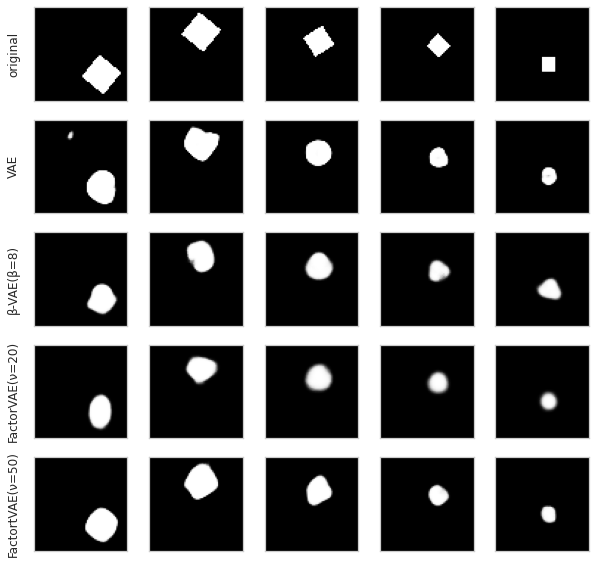

In [8]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig, axes = plt.subplots(len(models) + 1, batch_size, figsize=(2 * batch_size, 10))

images = np.concatenate([test_inputs[0].unsqueeze(0).numpy(), test_recons])

for j, (examp_imgs, ylab) in enumerate(zip(images, ['original'] + model_names)):
    for i, img in enumerate(examp_imgs):
        axes[j, i].imshow(img.reshape(64, 64), cmap='Greys_r')
        if i == 0:
            axes[j, i].set_ylabel(ylab)
    
for ax in axes.reshape(-1):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
# fig.suptitle('VAE reconstruction on training set');
# fig.savefig(presentation_folder + 'blank_side_training_reconstructions.pdf')

## Scores

In [9]:
nll = get_metric({'name': 'recons_nll', 'params': {'loss': 'bce'}})

training_scores = model_scores(models, train_data.get_unsupervised(), model_names, {'nll': nll}, device)
test_scores = model_scores(models, test_data.get_unsupervised(), model_names, {'nll': nll}, device)

scores = pd.concat([training_scores, test_scores], names=['Data'], keys=['Training', 'Test'])
scores = scores.reset_index()
scores.columns = ['Data', 'Model', 'NLL']

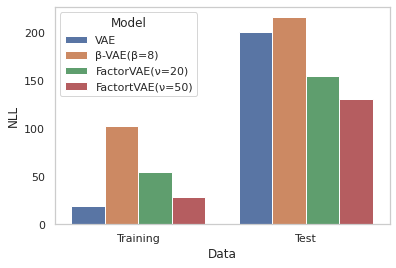

In [10]:
sns.barplot(data=scores, x='Data', y='NLL', hue='Model');

## Disentanglement

In [11]:
metric_data = DataLoader(train_data.get_supervised(), batch_size=128)
eastwood = DCIMetrics(metric_data, n_factors=5)

vae_scores = eastwood(vae)
vea_R = vae_scores.R_coeff

beta_8_scores = eastwood(beta_8)
beta_8_R = beta_8_scores.R_coeff

factor_20_scores = eastwood(factor_20)
factor_20_R = factor_20_scores.R_coeff

factor_50_scores = eastwood(factor_50)
factor_50_R = factor_50_scores.R_coeff

total_disent_score, disent_scores, completness_scores = zip(vae_scores.get_scores(), 
                                                            beta_8_scores.get_scores(),
                                                            factor_20_scores.get_scores(),
                                                            factor_50_scores.get_scores())
R_matrices = [vea_R, beta_8_R, factor_20_R, factor_50_R]

In [12]:
factors = metric_data.dataset.lat_names

idx = pd.MultiIndex.from_product([model_names, range(len(disent_scores[0]))], names=['models', 'latent'])
disent_scores = pd.Series(np.concatenate(disent_scores), index=idx)
disent_scores.name = 'disentanglement'

idx = pd.MultiIndex.from_product([model_names, factors], names=['models', 'factor'])
completness_scores = pd.Series(np.concatenate(completness_scores), index=idx)
completness_scores.name = 'completeness'

idx = pd.MultiIndex.from_product([model_names], names=['models'])
overall_disent_score = pd.Series(total_disent_score, index=idx)
overall_disent_score.name = 'overall disentanglement'

extrapol_disent_score = overall_disent_score

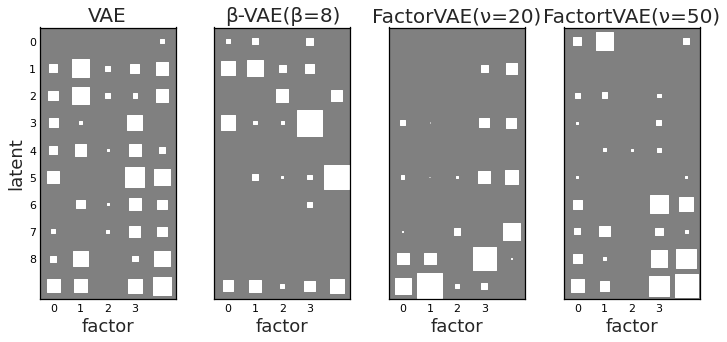

In [13]:
from analysis.hinton import hinton

fig, axes = plt.subplots(1, 4, figsize=(3 * len(models), 5), sharey=True)

for i in range(len(model_names)):
    hinton(R_matrices[i], 'factor', 'latent', ax=axes[i], fontsize=18)
    axes[i].set_title('{0}'.format(model_names[i]), fontsize=20)
    if i > 0:
        axes[i].set_ylabel('')
    
# fig.savefig(presentation_folder + 'blank_side_training_r_matrices.pdf')

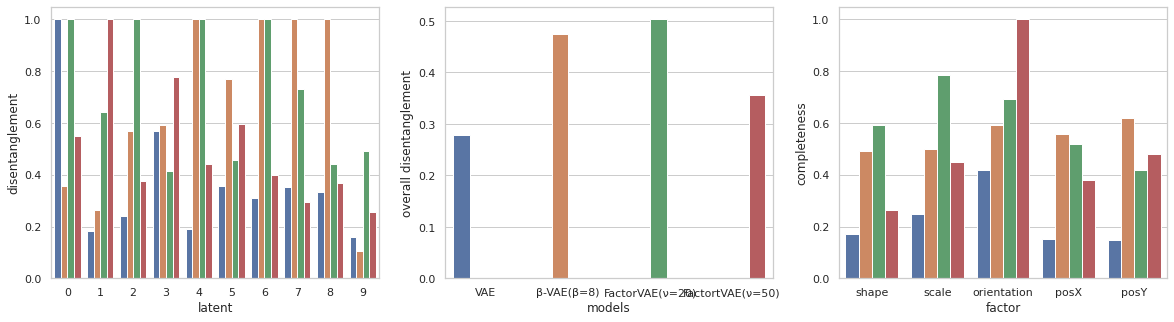

In [14]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, axes = plt.subplots(1, 3, figsize=(20, 5))


sns.barplot(data=disent_scores.reset_index(), hue='models', x='latent', y='disentanglement', ax=axes[0])
sns.barplot(data=overall_disent_score.reset_index(), hue='models', x='models', y='overall disentanglement', ax=axes[1])
sns.barplot(data=completness_scores.reset_index(), hue='models', x='factor', y='completeness', ax=axes[2])

axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()

# fig.savefig(presentation_folder + 'blank_side_training_dis.pdf')

## Comparing embeddings

In [ ]:
loader = DataLoader(train_data.get_supervised(), batch_size=64)
test_loader = DataLoader(test_data.get_supervised(), batch_size=64)

train_emb, train_lat = infer(factor_20, loader)
test_emb, test_lat = infer(factor_20, test_loader)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor as LOF

def get_corresponding_latents(instance, latent_vals, dim):
    idx = latent_vals.new_ones(len(latent_vals), dtype=torch.bool)
    
    for l in range(latent_vals.size(1)):
        if l != dim:
            idx &= latent_vals[:, l] == instance[l]
            
    return idx

In [ ]:
corresp_emb.size()

In [ ]:
outliers = 0

for z, gt in zip(test_emb, test_lat):
    idx = get_corresponding_latents(gt, train_lat, 0)
    corresp_emb = train_emb[idx]
    
    outlier = LOF(novelty=True, n_neighbors=len(corresp_emb)).fit(corresp_emb.numpy()).predict(z)
    
    outliers += outlier
    
print(outliers/len(outliers))